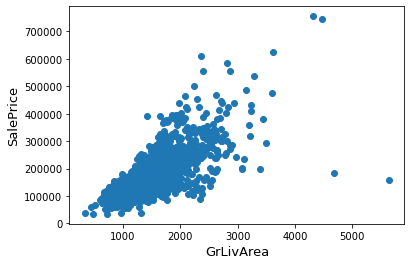

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
dirname=os.getcwd()
data_dir=os.path.join(dirname,"house-prices-advanced-regression-techniques")
train_path = os.path.join(data_dir,"train.csv")
test_path = os.path.join(data_dir,"test.csv")
x_train = pd.read_csv(str(train_path))
x_test = pd.read_csv(str(test_path))
fig, ax = plt.subplots()
ax.scatter(x = x_train['GrLivArea'], y = x_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()   


In [2]:
#drop outlier
x_train = x_train.drop(x_train[(x_train['GrLivArea']>4000)].index)
train_ID = x_train['Id']
test_ID = x_test['Id']   
x_train.drop('Id', axis = 1, inplace = True)
x_test.drop('Id', axis = 1, inplace = True)
train = x_train.shape[0]
# data smoothing
x_train["SalePrice"] = np.log1p(x_train["SalePrice"])
y_train = x_train.pop('SalePrice')
y_train = pd.DataFrame(y_train)
all_data = pd.concat((x_train,x_test)).reset_index(drop=True)

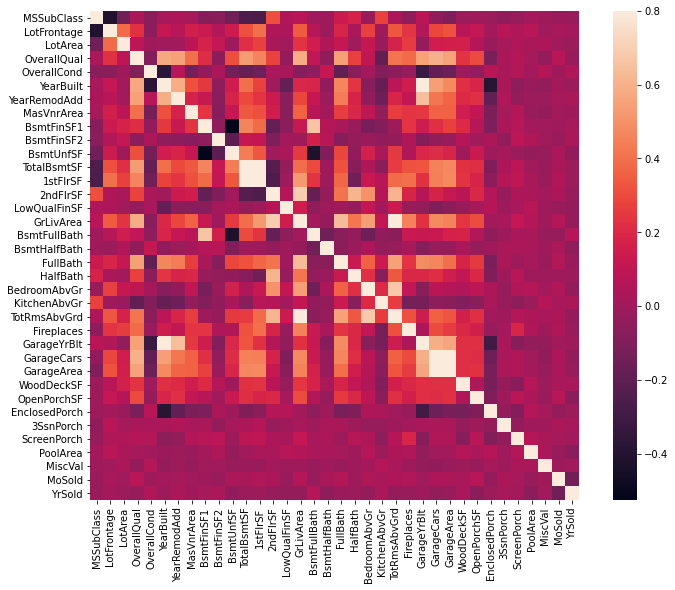

In [3]:
corrmat = x_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [4]:
# Impute Nan values according to data_description.txt
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None") 
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None") 
all_data['FireplaceQu']=all_data['FireplaceQu'].fillna(all_data['FireplaceQu'].mode()[0])
all_data['LotFrontage']=all_data['LotFrontage'].fillna(all_data['LotFrontage'].median())
all_data['GarageYrBlt']=all_data['GarageYrBlt'].fillna(0)
all_data['GarageType']=all_data['GarageType'].fillna("None")
all_data['GarageFinish']=all_data['GarageFinish'].fillna("None")
all_data['GarageQual']=all_data['GarageQual'].fillna("None")
all_data['GarageCond']=all_data['GarageCond'].fillna("None")
all_data['BsmtFinType2']=all_data['BsmtFinType2'].fillna("None")
all_data['BsmtExposure']=all_data['BsmtExposure'].fillna("None")
all_data['BsmtFinType1']=all_data['BsmtFinType1'].fillna("None")
all_data['BsmtCond']=all_data['BsmtCond'].fillna("None")
all_data['BsmtQual']=all_data['BsmtQual'].fillna("None")
all_data['MasVnrArea']=all_data['MasVnrArea'].fillna(0)
all_data['MasVnrType']=all_data['MasVnrType'].fillna("None")
all_data['Electrical']=all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['MSZoning']=all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Functional']=all_data['Functional'].fillna(all_data['Functional'].mode()[0])
all_data['Utilities']=all_data['Utilities'].fillna(all_data['Utilities'].mode()[0])
all_data['SaleType']=all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['GarageArea']=all_data['GarageArea'].fillna(0)
all_data['GarageCars']=all_data['GarageCars'].fillna(0)
all_data['KitchenQual']=all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['TotalBsmtSF']=all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtUnfSF']=all_data['BsmtUnfSF'].fillna(0)
all_data['BsmtFinSF2']=all_data['BsmtFinSF2'].fillna(0)
all_data['BsmtFinSF1']=all_data['BsmtFinSF1'].fillna(0)
all_data['Exterior2nd']=all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['Exterior1st']=all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['BsmtHalfBath']=all_data['BsmtHalfBath'].fillna(0)
all_data['BsmtFullBath']=all_data['BsmtFullBath'].fillna(0)
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#Feature engineering
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] 

# data smoothing
for feature in all_data:
    if all_data[feature].dtype != "object":
            all_data[feature] = np.log1p(all_data[feature])
                

categorical_features =['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallQual','OverallCond', 'YrSold', 'MoSold','MSSubClass']

for category in categorical_features:
    label = LabelEncoder() 
    label.fit(list(all_data[category].values))
    all_data[category] = label.transform(list(all_data[category].values))

all_data = pd.get_dummies(all_data)
x_train = all_data[:train]
x_test = all_data[train:]

In [5]:
model = lgb.LGBMRegressor(objective='regression')
model.fit(x_train, y_train)
prediction = np.expm1(model.predict(x_test))#data smoothing
result = pd.DataFrame()
result['Id'] = test_ID
result['SalePrice'] = prediction
result.to_csv('submission_LGB.csv',index=False)